## Dataset - CIFAR10
## Initialisation
Import necessary libraries and initialise device

In [1]:
import torch
import torchvision
from torchvision import models
from torchvision import datasets
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset
### Introduction
The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order.

### Loading
We are loading dataset and building dataloaders. Batch size 128 is used, because thats what AlexNet was originally trained with.

In [2]:
transform = transforms.Compose([        
    transforms.Resize(256),                # Resize the image to 256×256 pixels
    transforms.CenterCrop(224),            # Crop image to 224×224 pixels
    transforms.ToTensor(),                 
    transforms.Normalize(                  
    mean=[0.485, 0.456, 0.406],            
    std=[0.229, 0.224, 0.225]      
 )])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

print("Size of training set:",len(trainset))
print("Size of test set:",len(testset))

100%|██████████| 170498071/170498071 [00:03<00:00, 46899231.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Size of training set: 50000
Size of test set: 10000


Visualise the dataset

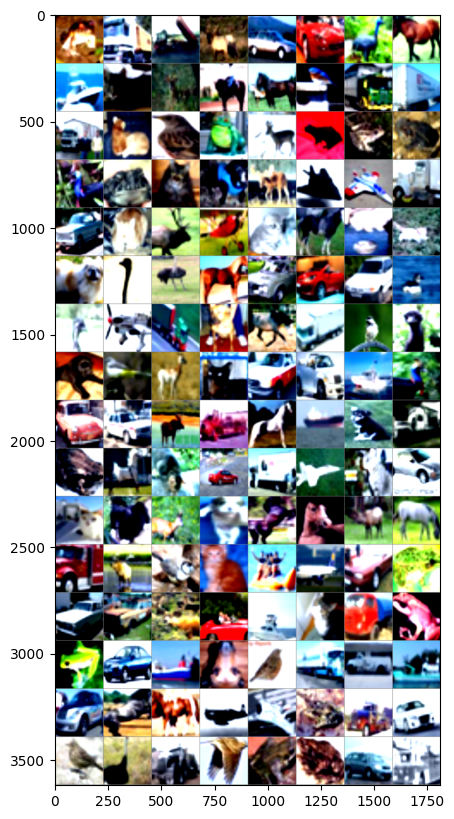

In [3]:
def imshow(img):
    npimg = img.cpu().numpy()
    npimg = npimg / 2 + 0.5
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))

Print name of classes in dataset

In [4]:
classes = trainset.classes
print("Number of classes: {}".format(len(classes)))
print(classes)

Number of classes: 10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Model : AlexNet
### Introduction
AlexNet was the first convolutional network which used GPU to boost performance. It is trained on imagenet dataset.

### Architecture
![Alt text](AlexNet.png)

### Model specifications
1.      AlexNet architecture consists of 5 convolutional layers, 3 max-pooling layers, 2 normalization layers, 2 fully connected layers, and 1 softmax layer. 

2.      Each convolutional layer consists of convolutional filters and a nonlinear activation function ReLU. 

3.      The pooling layers are used to perform max pooling. 

5.      The input size is 224x224x3.

6.      AlexNet overall has 60 million parameters.


### Loading pre-trained AlexNet
Loading pre-trained AlexNet model and change output layer size to 10 because CIFAR10 has 10 classes, meanwhile AlexNet is trained on imagenet dataset that has 1000 classes


In [5]:
alexnet_pre = models.alexnet(pretrained=True).to(device)
alexnet_pre.classifier[6] = torch.nn.Linear(4096, 10) #output size = 10 for cifar10

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 319MB/s] 


Define our own network with same structure as AlexNet because we want to fine-tune it to CIFAR10. This also allows us to push the weights onto GPU for much faster training.

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2).to(device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2).to(device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)).to(device)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096).to(device),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096).to(device),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes).to(device)
        )

    def forward(self, x):
        x = self.features(x.to(device))
        x = self.avgpool(x.to(device))
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x.to(device))
        probas = nn.functional.softmax(logits, dim=1)
        return logits
    
alexnet_model = AlexNet(10) # 10 = number of classes

Perform transfer learning from pre-trained AlexNet

In [7]:
for i, (pretrained_param, new_param) in enumerate(zip(alexnet_pre.parameters(), alexnet_model.parameters())):
    if i < 6:  
        new_param.data.copy_(pretrained_param.data)
    elif i == 6:
        nn.init.xavier_uniform_(alexnet_model.classifier[6].weight)
        nn.init.zeros_(alexnet_model.classifier[6].bias)
    else: 
        new_param.requires_grad = False

Print architecture of our model.

In [8]:
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Train and fine-tune our model, to update the weights for the newly added last layer

In [9]:
# Test the model before training last layer
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Before fine-tuning  - Accuracy on test set: {correct/total*100:.2f}%")

Before fine-tuning  - Accuracy on test set: 9.78%


In [10]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)

# Fine-tune the model

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss/len(trainloader):.3f}")

# Test the model again after fine-tuning
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"After fine-tuning  - Accuracy on test set: {correct/total*100:.2f}%")

[Epoch 1] Loss: 2.283
[Epoch 2] Loss: 2.150
[Epoch 3] Loss: 2.000
[Epoch 4] Loss: 1.885
[Epoch 5] Loss: 1.798
[Epoch 6] Loss: 1.726
[Epoch 7] Loss: 1.661
[Epoch 8] Loss: 1.612
[Epoch 9] Loss: 1.562
[Epoch 10] Loss: 1.534
After fine-tuning  - Accuracy on test set: 47.11%


**Sample classification** with pre-trained and fine-tuned model

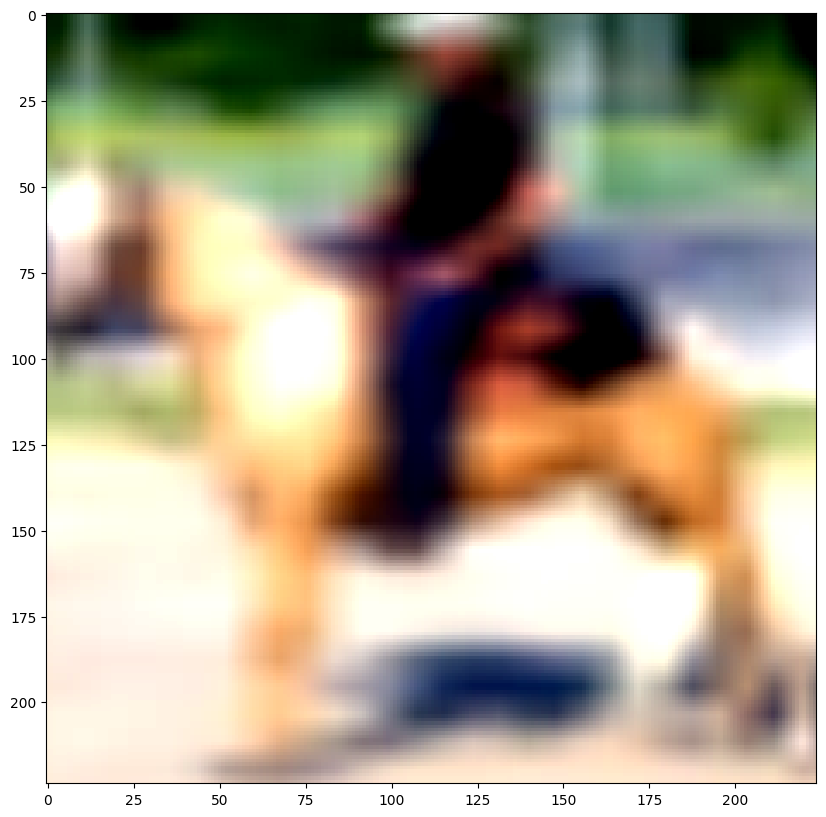

[('horse', 39.990596771240234),
 ('dog', 37.11703109741211),
 ('frog', 6.161536693572998),
 ('bird', 4.799152374267578),
 ('deer', 4.036999225616455)]

In [11]:
# first image
imshow(torchvision.utils.make_grid(images[0]))
out = alexnet_model(torch.unsqueeze(images[0], 0))

# print top 5 classes guessed by the model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim = 1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

# DeepCluster
## Step 1: Get Image representation
We are taking image representation from fc6 layer of AlexNet. We chose to use the fc6 layer of the CNN as feature representation because this layer provides a high-level, semantically meaningful representation of the input image. The fc6 layer is the first fully connected layer of the CNN, and it contains 4096 neurons. Each neuron in the fc6 layer corresponds to a high-level feature detector, which captures a specific pattern or concept in the input image.

In [12]:
def get_features(trainloader,testloader):
  alexnet_model.eval()
  features = []
  with torch.no_grad():
    for images, labels in trainloader:
      inputs = torch.cat((images.to(device),), dim=0)
      output = alexnet_model.features(inputs)
      output = output.view(output.size(0), -1)
      output = alexnet_model.classifier[1](output)
      features.append(output)

    for images, labels in testloader:
      inputs = torch.cat((images.to(device),), dim=0)
      output = alexnet_model.features(inputs)
      output = output.view(output.size(0), -1)
      output = alexnet_model.classifier[1](output)
      features.append(output)
    
  return features

## Step 2 : Perform dimensionality reduction
We are using PCA for dimensionality reduction before clustering. PCA can eliminate redundant information from the dataset by identifying and removing highly correlated variables.

In [13]:
def reduce_dimensionality(features,new_dim = 256):
  principal = PCA(n_components=new_dim)
  principal.fit(features.detach().cpu().numpy())
  new_features = principal.transform(features.detach().cpu().numpy())
  print("Reduced dimensions: ",new_features.shape)
  return new_features

## Step 3 : Clustering
We are clustering image representation vector and these clusters assigned obtained from this step are used to assign pseudo-labels to the data.

We use **Kmeans** clustering algorithm,
K-Means Clustering is an Unsupervised Learning algorithm, which groups the unlabeled dataset into different clusters.

In [14]:
def get_clusters(features,k = 10):
  features = torch.from_numpy(features)
  features = [tensor.detach().reshape(1, -1) for tensor in features]
  features = torch.cat(features, dim=0).numpy()

  kmeans = KMeans(n_clusters = k, random_state=0, n_init = 10).fit(features)
  pseudolabels = kmeans.labels_ # Obtained labels
  print('Clustering done.')
    
  # Plot the clusters
  plt.scatter(features[:, 0], features[:, 1], c=pseudolabels, cmap='viridis')
  plt.show()

  return pseudolabels,kmeans.inertia_


## Step 4 : Update labels
We are updating labels in dataset with pseudolabels obtained in the clustering step. Now for further steps we will use these cluster labels as true labels for the daaset and train model end-to-end.

In [15]:
def update_labels(trainset,testset,pseudolabels):
  # Update trainset labels
  for i in range(len(trainset)):
    trainset.targets[i] = pseudolabels[i]
  
  # Update testset labels
  for i in range(len(testset)):
    testset.targets[i] = pseudolabels[i+len(trainset)]

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=0)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)
  print('Labels updated.')
  return trainset, testset, trainloader, testloader


## Step 5 : Training & Testing
We are training the model end-to-end using the cluster labels as pseudo-labels. Then we test our model to see how our accuracy on test set has changed.
We are also saving our model at each epoch and plotting loss vs epoch graph to visualise how the loss has changed.

In [16]:
def train(model,trainloader,optimizer,criterion,num_epochs = 2):
  model.train()
  all_loss = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].long().to(device)

        optimizer.zero_grad()

        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    all_loss.append(running_loss/len(trainloader))
#     torch.save(model.state_dict(), 'trained_model.pth')
    print(f"[Epoch {epoch+1}] Loss: {running_loss/len(trainloader):.3f}")

  # plot the test loss over epochs
  plt.plot(range(1, num_epochs+1), all_loss)
  plt.title('Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def test(model, testloader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, target in testloader:
      target = target.long().to(device)
      output = model(images.to(device))
      test_loss += criterion(output, target).cpu().data.item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(testloader.dataset)
  accuracy = 100. * correct / len(testloader.dataset)
  print('Test set: Average loss: {:.3f}, Accuracy: {}/{} ({:.0f}%)'.format(
      test_loss, correct, len(testloader.dataset), accuracy))

## Opitmizer and Loss function
### SGD with momentum optimiser 
The problem with SGD is that while it tries to reach minima because of the high oscillation we can’t increase the learning rate. So it takes time to converge. We will be using Exponentially Weighted Averages to compute Gradient and used this Gradient to update parameter. Momentum is taken as 0.9 as AlexNet was trained on this momentum.

### Cross-entropy loss
Also called logarithmic loss, log loss or logistic loss. Each predicted class probability is compared to the actual class desired output 0 or 1 and a loss is calculated that penalizes the probability based difference from actual expected value. 
The penalty is logarithmic, so it gives a large loss for large differences close to 1 and small loss for small differences tending to 0.

In [17]:
#Initialize optimizer and loss function
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

# Main : Driver code
We run our whole process for multiple iterations, we can either perform clustering at each iteration or once every few iterations.

In [18]:
def main(model,trainset,testset,trainloader,testloader,optimizer,criterion,num_clusters,new_dim,epochs=2):
    
  # Get image representation
  features = get_features(trainloader,testloader)
  features = torch.cat(features, dim=0)
  #PCA
  features = reduce_dimensionality(features,new_dim)
  #Clustering
  pseudolabels,elbow_i = get_clusters(features,num_clusters)

  targets1 = torch.cat([batch[1] for batch in trainloader], dim=0)
  targets2 = torch.cat([batch[1] for batch in testloader], dim=0)
  concatenated_targets = torch.cat([targets1, targets2], dim=0)
    
  #Update labels
  trainset,testset,trainloader,testloader = update_labels(trainset,testset,pseudolabels)
  #train alexnet
  train(model,trainloader,optimizer,criterion,epochs)
  #test alexnet
  test(model,testloader,criterion)
  
  nmi = normalized_mutual_info_score(concatenated_targets, pseudolabels)

  return elbow_i,nmi

Run the driver code for multiple values for number of clusters.

Reduced dimensions:  (60000, 256)
Clustering done.


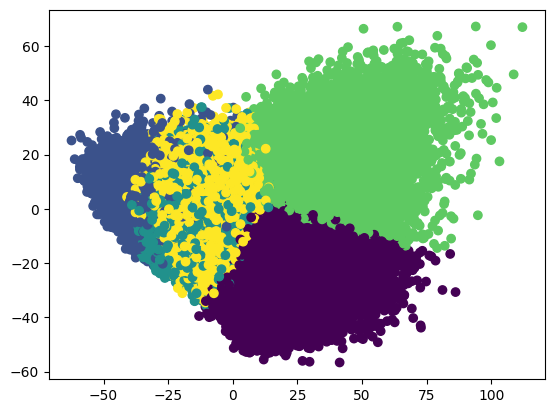

Labels updated.
[Epoch 1] Loss: 1.252
[Epoch 2] Loss: 0.838
[Epoch 3] Loss: 0.719


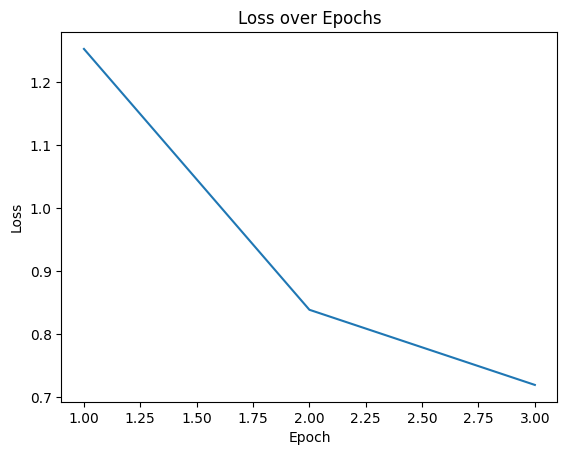

Test set: Average loss: 0.003, Accuracy: 8380/10000 (84%)
-------------- ITERATION 1 for K = 5 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


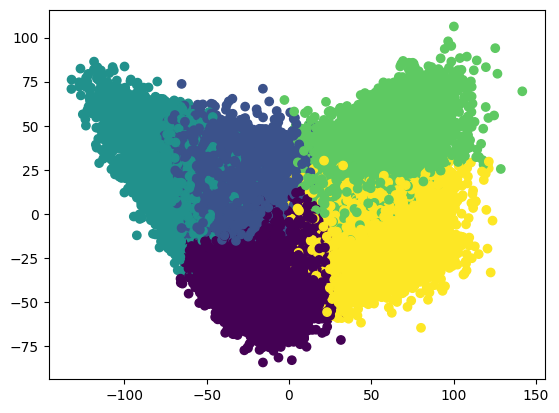

Labels updated.
[Epoch 1] Loss: 1.252
[Epoch 2] Loss: 0.858
[Epoch 3] Loss: 0.733


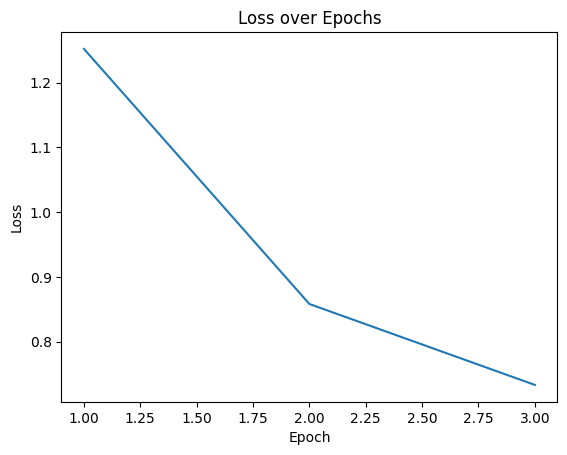

Test set: Average loss: 0.003, Accuracy: 8258/10000 (83%)
-------------- ITERATION 2 for K = 5 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


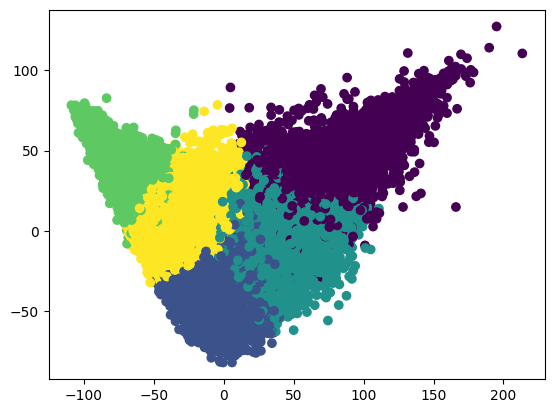

Labels updated.
[Epoch 1] Loss: 1.406
[Epoch 2] Loss: 0.896
[Epoch 3] Loss: 0.739


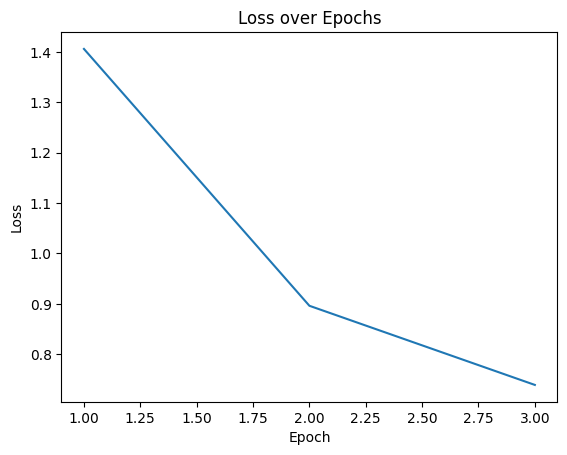

Test set: Average loss: 0.003, Accuracy: 8421/10000 (84%)
-------------- ITERATION 3 for K = 5 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


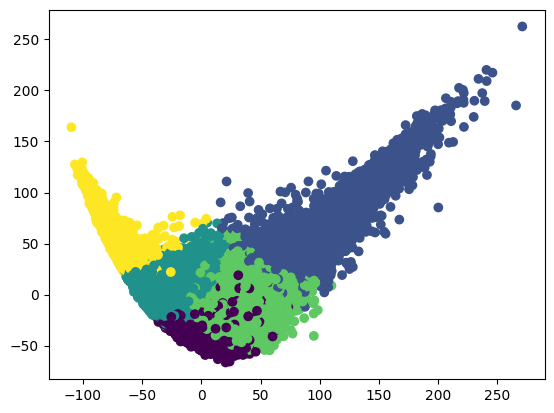

Labels updated.
[Epoch 1] Loss: 1.227
[Epoch 2] Loss: 0.735
[Epoch 3] Loss: 0.622


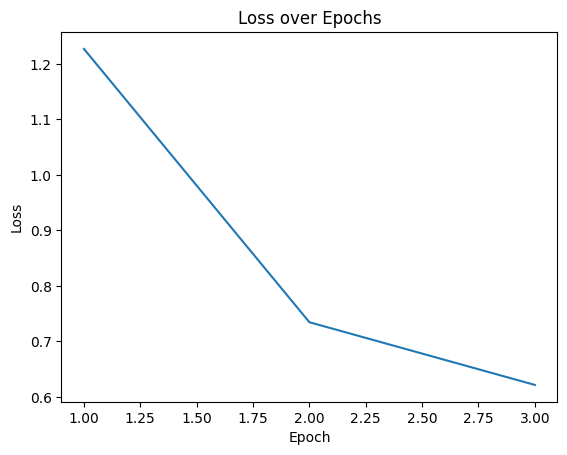

Test set: Average loss: 0.002, Accuracy: 8834/10000 (88%)
-------------- ITERATION 4 for K = 5 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


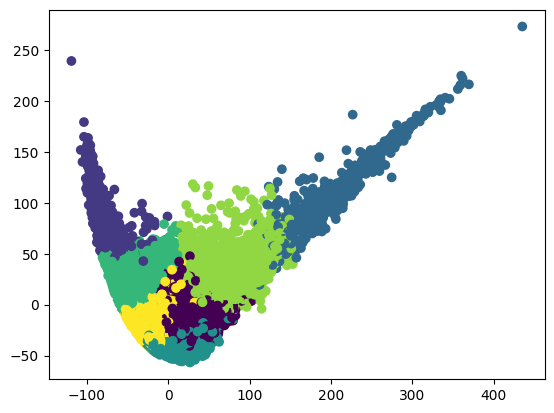

Labels updated.
[Epoch 1] Loss: 1.545
[Epoch 2] Loss: 1.072
[Epoch 3] Loss: 0.928


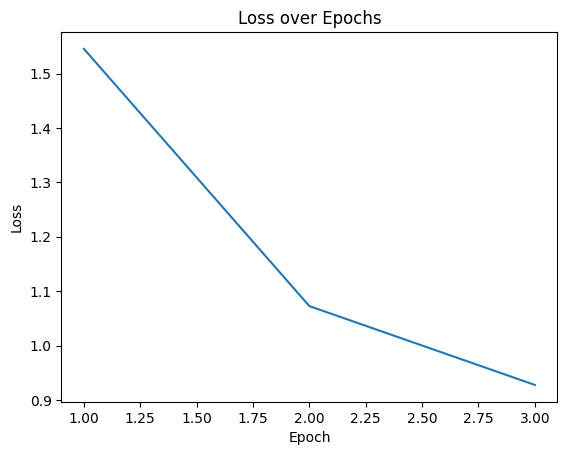

Test set: Average loss: 0.004, Accuracy: 8080/10000 (81%)
-------------- ITERATION 1 for K = 7 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


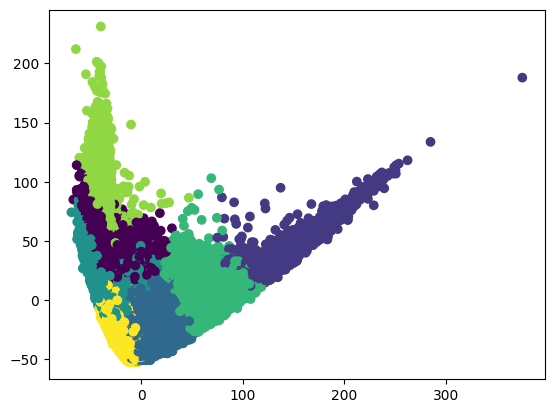

Labels updated.
[Epoch 1] Loss: 1.033
[Epoch 2] Loss: 0.788
[Epoch 3] Loss: 0.715


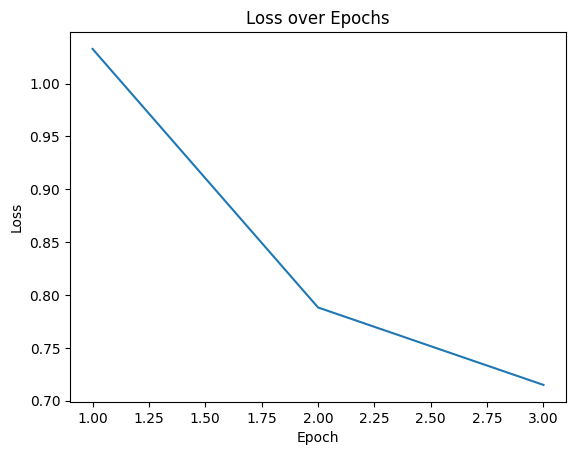

Test set: Average loss: 0.003, Accuracy: 8848/10000 (88%)
-------------- ITERATION 2 for K = 7 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


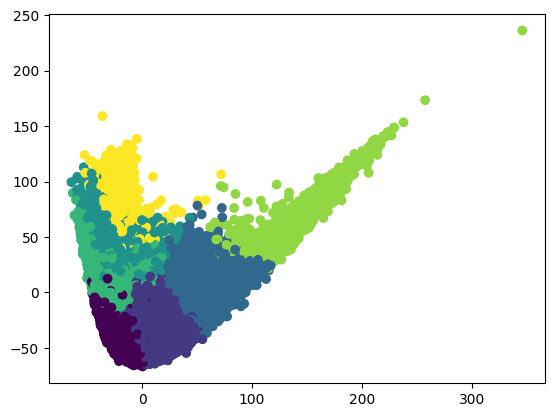

Labels updated.
[Epoch 1] Loss: 1.478
[Epoch 2] Loss: 0.982
[Epoch 3] Loss: 0.850


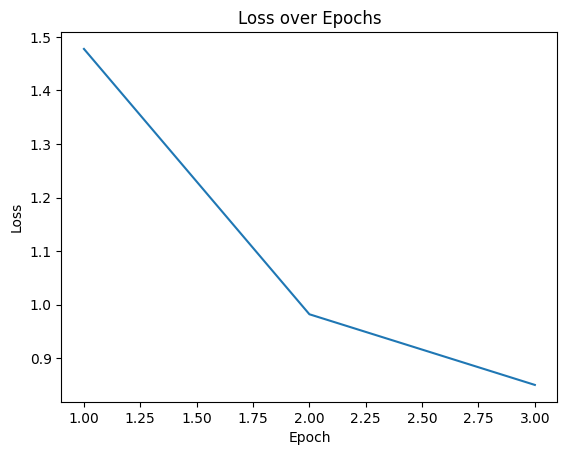

Test set: Average loss: 0.004, Accuracy: 8254/10000 (83%)
-------------- ITERATION 3 for K = 7 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


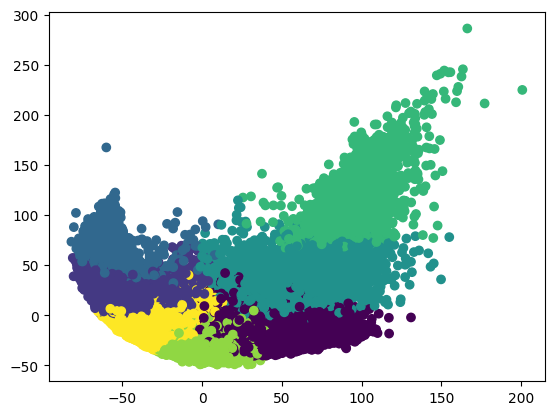

Labels updated.
[Epoch 1] Loss: 1.307
[Epoch 2] Loss: 0.936
[Epoch 3] Loss: 0.836


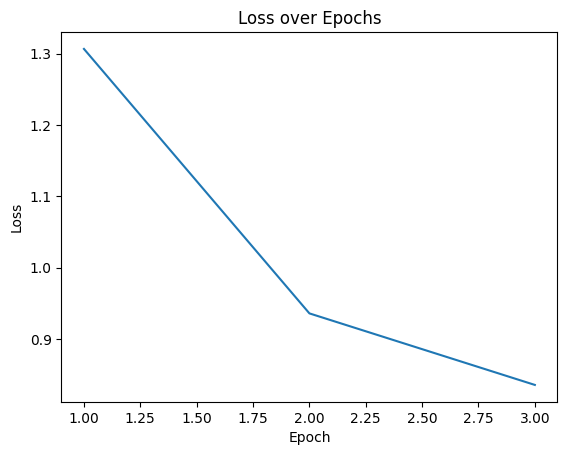

Test set: Average loss: 0.003, Accuracy: 8364/10000 (84%)
-------------- ITERATION 4 for K = 7 done! ------------------


In [19]:
epochs = 3 # Training epochs
new_dim = 256 # Reduced dimensions
num_clusters = [5,7,8,10]
elbow_s = {}
nmis_s = []
trainset_og,testset_og = trainset,testset
model_og = alexnet_model
for num_cluster in (num_clusters[:2]):
    num_iter = 4
    trainset,testset = trainset_og,testset_og
    alexnet_model = model_og
    nmis = {}
    for i in range(num_iter):
      elbow_s[num_cluster],nmis[i] = main(alexnet_model,trainset,testset,trainloader,testloader,optimizer,criterion,num_cluster,new_dim,epochs)
      print("-------------- ITERATION {} for K = {} done! ------------------".format(i+1,num_cluster))
    nmis_s.append(nmis)
    torch.save(alexnet_model.state_dict(), 'trained_model_'+ str(num_cluster) +'.pth')

Reduced dimensions:  (60000, 256)
Clustering done.


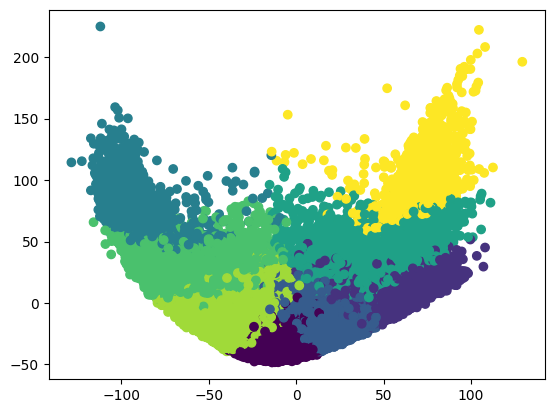

Labels updated.
[Epoch 1] Loss: 1.604
[Epoch 2] Loss: 1.179
[Epoch 3] Loss: 1.062


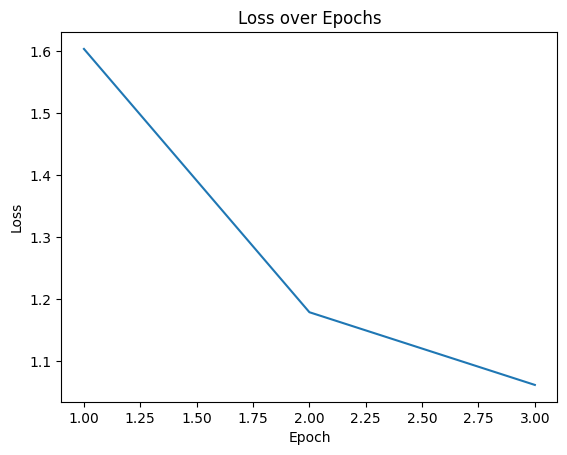

Test set: Average loss: 0.005, Accuracy: 7623/10000 (76%)
-------------- ITERATION 1 for K = 8 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


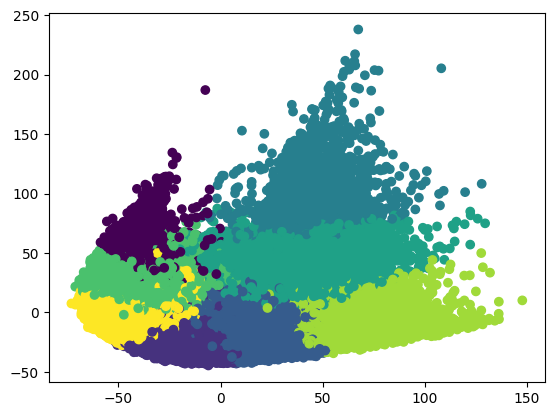

Labels updated.
[Epoch 1] Loss: 1.600
[Epoch 2] Loss: 1.255
[Epoch 3] Loss: 1.141


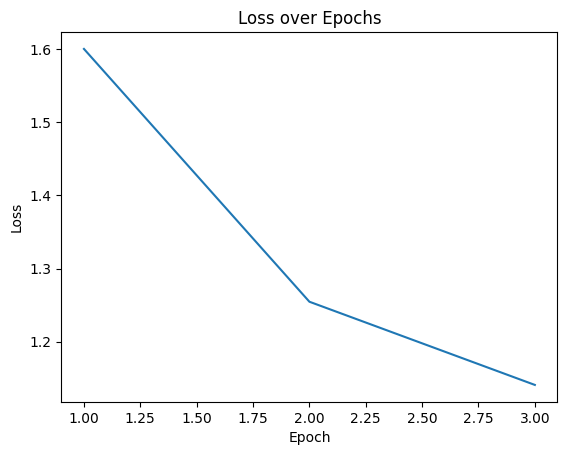

Test set: Average loss: 0.005, Accuracy: 8225/10000 (82%)
-------------- ITERATION 2 for K = 8 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


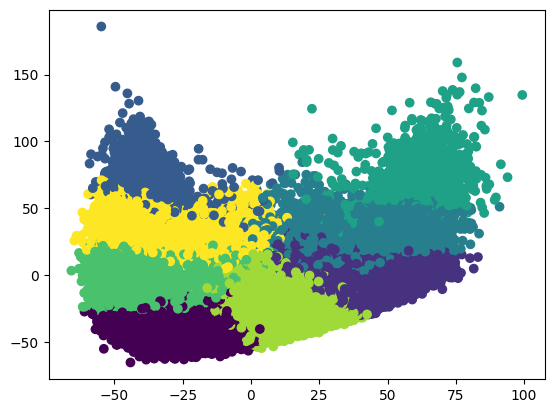

Labels updated.
[Epoch 1] Loss: 1.506
[Epoch 2] Loss: 1.118
[Epoch 3] Loss: 1.007


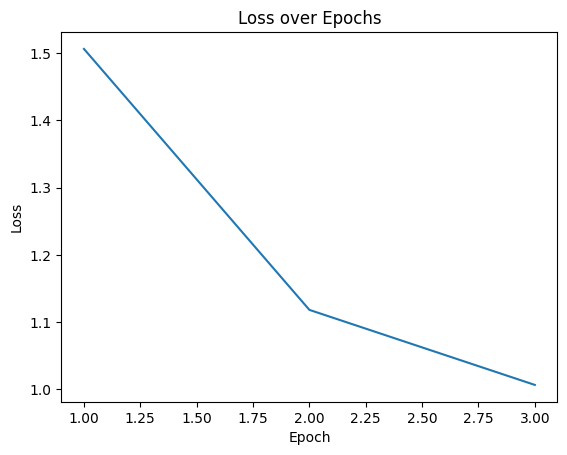

Test set: Average loss: 0.004, Accuracy: 8221/10000 (82%)
-------------- ITERATION 3 for K = 8 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


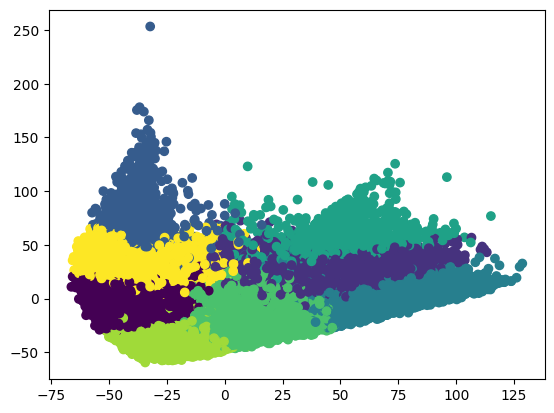

Labels updated.
[Epoch 1] Loss: 1.373
[Epoch 2] Loss: 1.091
[Epoch 3] Loss: 0.989


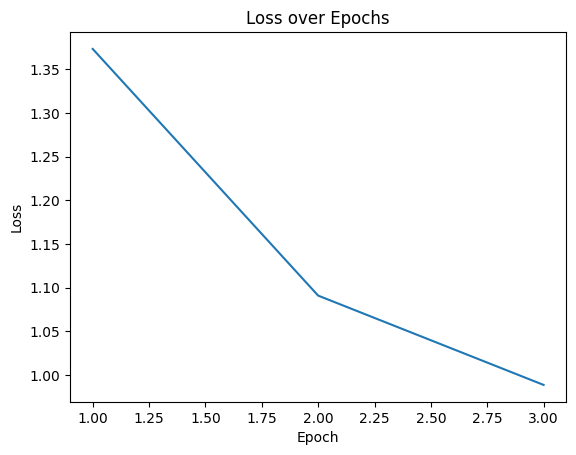

Test set: Average loss: 0.004, Accuracy: 7926/10000 (79%)
-------------- ITERATION 4 for K = 8 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


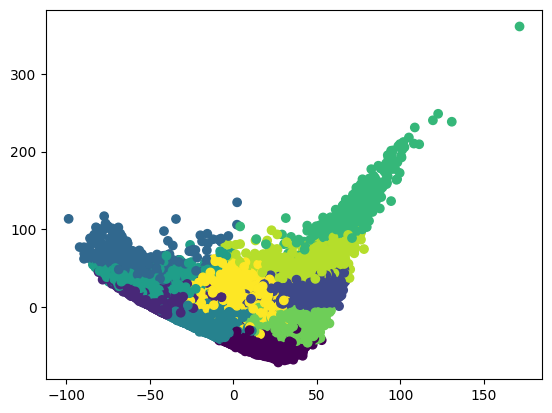

Labels updated.
[Epoch 1] Loss: 1.720
[Epoch 2] Loss: 1.369
[Epoch 3] Loss: 1.262


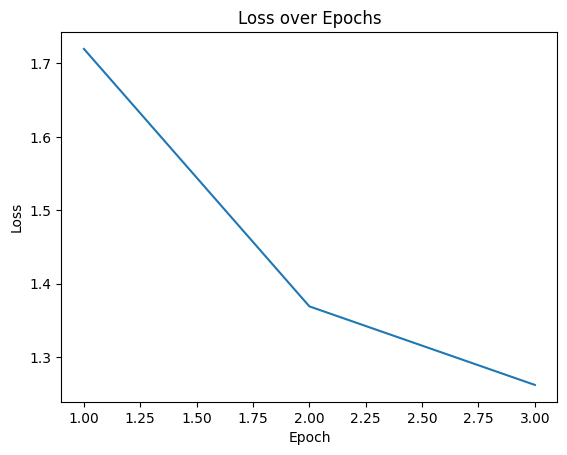

Test set: Average loss: 0.006, Accuracy: 7456/10000 (75%)
-------------- ITERATION 1 for K = 10 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


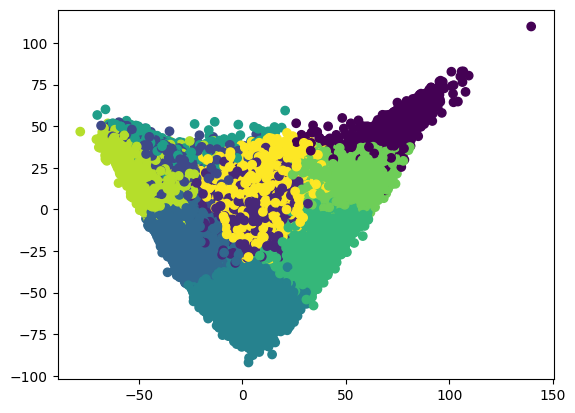

Labels updated.
[Epoch 1] Loss: 1.870
[Epoch 2] Loss: 1.545
[Epoch 3] Loss: 1.418


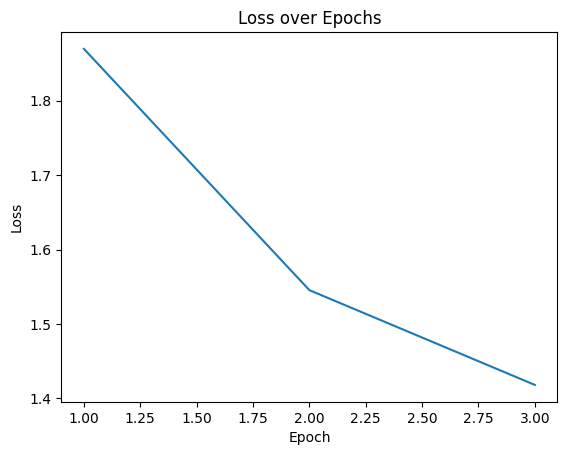

Test set: Average loss: 0.007, Accuracy: 7569/10000 (76%)
-------------- ITERATION 2 for K = 10 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


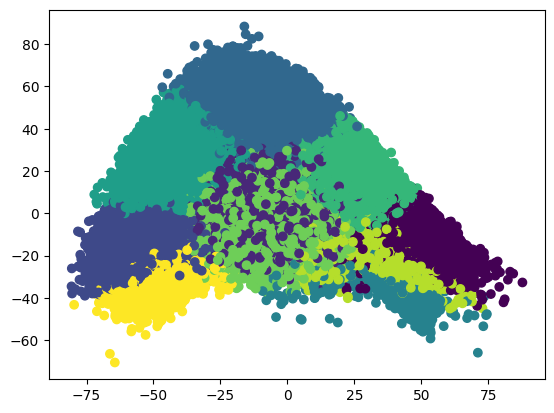

Labels updated.
[Epoch 1] Loss: 2.040
[Epoch 2] Loss: 1.712
[Epoch 3] Loss: 1.593


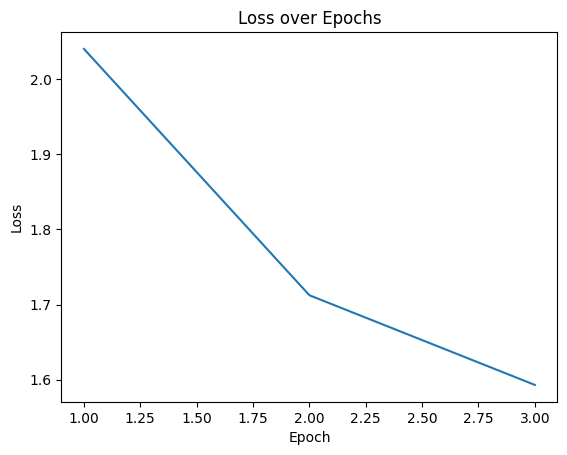

Test set: Average loss: 0.008, Accuracy: 6968/10000 (70%)
-------------- ITERATION 3 for K = 10 done! ------------------
Reduced dimensions:  (60000, 256)
Clustering done.


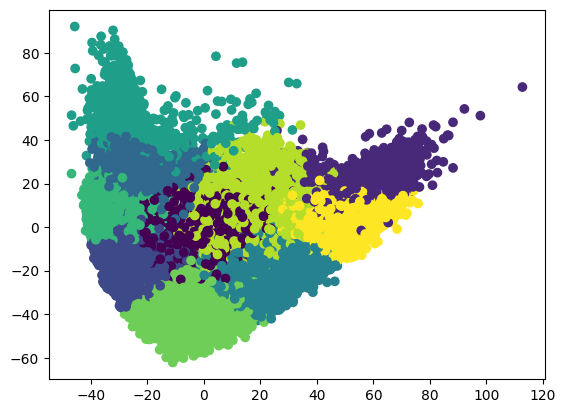

Labels updated.
[Epoch 1] Loss: 1.995
[Epoch 2] Loss: 1.783
[Epoch 3] Loss: 1.680


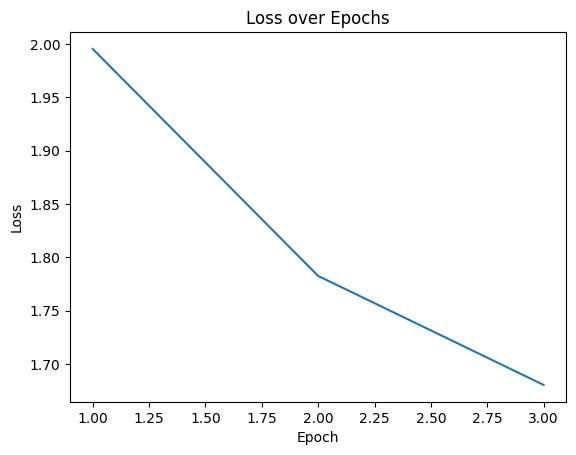

Test set: Average loss: 0.009, Accuracy: 6698/10000 (67%)
-------------- ITERATION 4 for K = 10 done! ------------------


In [20]:
for num_cluster in (num_clusters[2:]):
    num_iter = 4
    trainset,testset = trainset_og,testset_og
    alexnet_model = model_og
    nmis = {}
    for i in range(num_iter):
      elbow_s[num_cluster],nmis[i] = main(alexnet_model,trainset,testset,trainloader,testloader,optimizer,criterion,num_cluster,new_dim,epochs)
      print("-------------- ITERATION {} for K = {} done! ------------------".format(i+1,num_cluster))
    nmis_s.append(nmis)
    torch.save(alexnet_model.state_dict(), 'trained_model_'+ str(num_cluster) +'.pth')

### Optimal number of clusters
We use elbow method to find optimal number of clusters. The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use.

{5: 215538368.0, 7: 173867168.0, 8: 155267856.0, 10: 74117712.0}


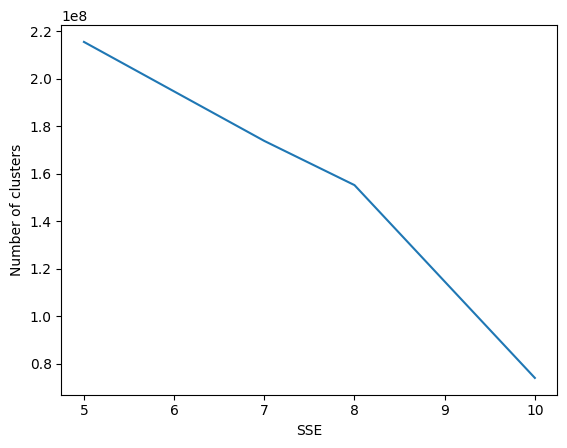

In [25]:
print(elbow_s)
plt.figure()
plt.plot(list(elbow_s.keys()), list(elbow_s.values()))
plt.xlabel("SSE")
plt.ylabel("Number of clusters")
plt.show()

## NMI
Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).

[{0: 0.36838686292584494, 1: 0.6772892549588191, 2: 0.620617594768179, 3: 0.7090243148627863}, {0: 0.6818637316079083, 1: 0.6986477049125837, 2: 0.8353333571462155, 3: 0.7665246696928466}, {0: 0.6762878342111365, 1: 0.7580890263174045, 2: 0.7554301247026689, 3: 0.7719106177327734}, {0: 0.7013619033634332, 1: 0.739775668685808, 2: 0.7490009940709252, 3: 0.6865663396691222}]
K: 5


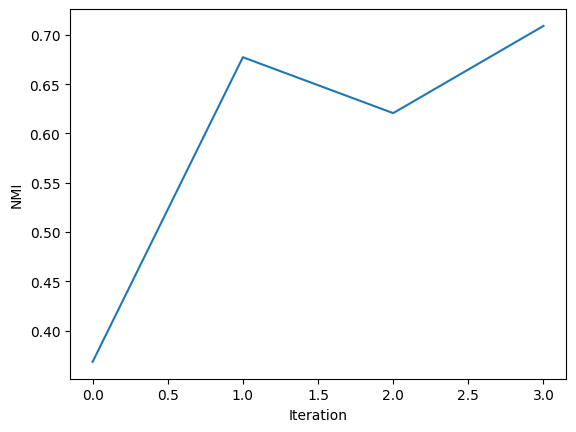

K: 7


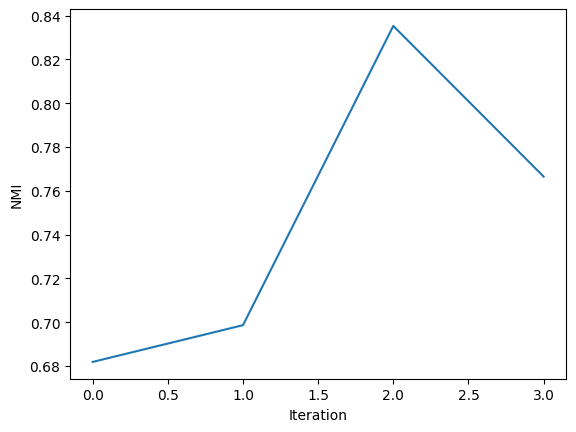

K: 8


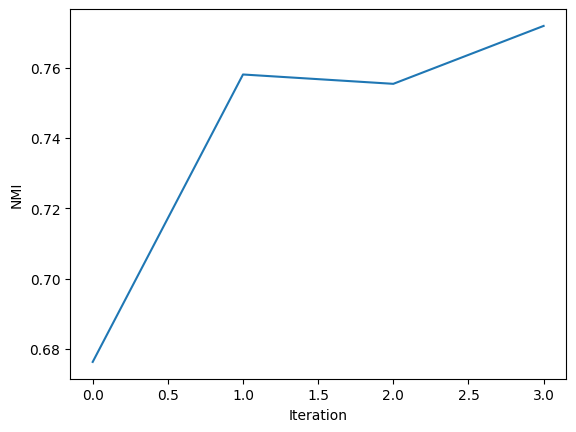

K: 10


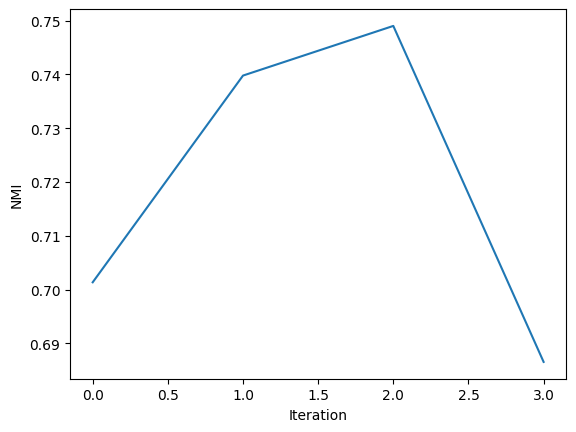

In [24]:
print(nmis_s)
for i in range(len(nmis_s)):
    print("K:",num_clusters[i])
    plt.figure()
    plt.plot(list(nmis_s[i].keys()), list(nmis_s[i].values()))
    plt.xlabel("Iteration")
    plt.ylabel("NMI")
    plt.show()

## Scope for further experimentations
1. We can try other dimensionality reduction techniques to see if we get better results.
2. Currently, we are working with 256 dimensions while clustering. We can experiment with number of reduced dimensions to see if we get better representation.
3. We can use different optimisers such as Adam, and also experiment with multiple values of learning rate and momentum in SGD.
4. Try for more number of epochs are more number of clusters.